<a href="https://colab.research.google.com/github/jeffj9930/3D_MRI_medical_imaging/blob/master/dataloader-120220.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
from torch.utils.data.dataset import Dataset
from glob import glob
import os
import random
from random import randint
from google.colab import drive

import nibabel as nib
import matplotlib.pyplot as plt
import sys
%matplotlib inline

index = 7

drive.mount('/content/gdrive',force_remount=True)
root_dir = "/content/gdrive/My Drive/"
image_dir = os.path.join(root_dir,'ml_files/medical_imaging/small/')
t1_dir = os.path.join(image_dir, 't1')
t2_dir = os.path.join(image_dir, 't2')


Mounted at /content/gdrive


In [101]:

class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transform=None):
        # Set initializations
        self.source_dir = source_dir
        self.target_dir = target_dir
        self.transform = transform
        
    def __len__(self):
        # Return number of files in directory
        source_files = glob(os.path.join(self.source_dir,'*'))
        return len(source_files)

    def __getitem__(self, idx):
        # Extract full volume from patient MRI
        source_files = glob(os.path.join(self.source_dir,'*'))
        target_files = glob(os.path.join(self.target_dir,'*'))
        imvol_t1 = nib.load(source_files[idx]).get_fdata()
        imvol_t2 = nib.load(target_files[idx]).get_fdata()
        imvols = (imvol_t1, imvol_t2)
        if self.transform:
          imvols = self.transform(imvols)
        print("Description of imvols : {} and length {}".format(type(imvols),len(imvols)))
        return imvols

In [113]:

class RandomCrop3D:
    def __init__(self, dims):
        if (type(dims) == int):
          self.dims = (dims, dims, dims)
        else:
          assert len(dims) == 3
          self.dims = dims

    def __call__(self, sample):
        imvol_t1, imvol_t2 = sample
        print(type(imvol_t1),imvol_t1.shape)
        assert imvol_t1.shape == imvol_t2.shape
        depth, height, width = imvol_t1.shape
        d, h, w = self.dims
        assert ((depth > d) and (height > h) and (width > w))
        x, y, z = (randint(0,(depth - d)), randint(0,(height - h)), randint(0,(width - w)))
        print("x : {}, y : {}, z : {}".format(x,y,z))
        cropvol_t1 = imvol_t1[x:x+d,y:y+h,z:z+w]
        cropvol_t2 = imvol_t2[x:x+d,y:y+h,z:z+w]
        print(cropvol_t1.shape, cropvol_t2.shape)
        sample = (cropvol_t1, cropvol_t2)
        print("Crop type : {}".format(type(sample)))
        return sample
        


In [114]:
print("Number of files per directory : {}".format(NiftiDataset(t1_dir, t2_dir).__len__()))
print("Number of items in selection : {}".format(NiftiDataset(t1_dir, t2_dir).__getitem__(index).__len__()))

Number of files per directory : 28
Description of imvols : <class 'tuple'> and length 2
Number of items in selection : 2


In [115]:
new_sample = NiftiDataset(t1_dir, t2_dir).__getitem__(index)
vol_t1, vol_t2 = new_sample

Description of imvols : <class 'tuple'> and length 2


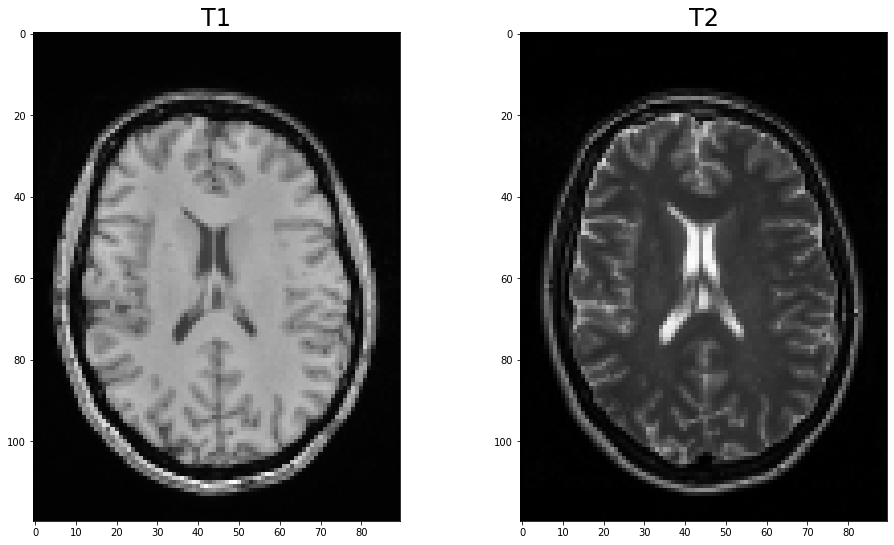

In [119]:
slice_idx = 75
slice_t1 = vol_t1[:,slice_idx,:]
slice_t2 = vol_t2[:,slice_idx,:]
fig, axes = plt.subplots(1,2,figsize=(16,9))
axes[0].imshow(slice_t1,cmap='gray');axes[0].set_title('T1',fontsize=24)
axes[1].imshow(slice_t2,cmap='gray');axes[1].set_title('T2',fontsize=24)
plt.show()

In [120]:

#crop_sample = NiftiDataset(source_dir=t1_dir, target_dir=t2_dir,transform=RandomCrop3D((60,60,60)))
crop_sample = NiftiDataset(source_dir=t1_dir, target_dir=t2_dir,transform=RandomCrop3D(60)).__getitem__(index)
cropvol_t1, cropvol_t2 = crop_sample
print("Final form : {} - {}".format(type(cropvol_t1),cropvol_t1.shape))

<class 'numpy.ndarray'> (120, 120, 90)
x : 7, y : 32, z : 10
(60, 60, 60) (60, 60, 60)
Crop type : <class 'tuple'>
Description of imvols : <class 'tuple'> and length 2
Final form : <class 'numpy.ndarray'> - (60, 60, 60)


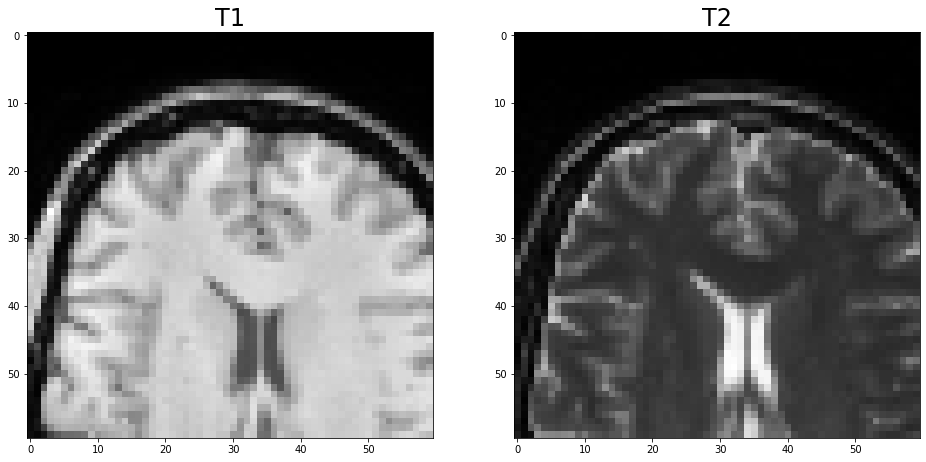

In [121]:
# Using above x, y, z as offset you can select slice to match above source images
y = 32
slice_t1 = cropvol_t1[:,slice_idx-y,:]
slice_t2 = cropvol_t2[:,slice_idx-y,:]
fig, axes = plt.subplots(1,2,figsize=(16,9))
axes[0].imshow(slice_t1,cmap='gray');axes[0].set_title('T1',fontsize=24)
axes[1].imshow(slice_t2,cmap='gray');axes[1].set_title('T2',fontsize=24)
plt.show()